In [113]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('ggplot')
%matplotlib inline
from tqdm import tqdm
from multitest import MultiTest


In [114]:
from scipy.interpolate import interp1d
import pandas as pd

In [115]:
import numpy as np
import torch
import os
#from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AutoModelForCausalLM, GPT2LMHeadModel

# Process


### At Training
 - Decide on a model + context (or a proxy model)
 - Get data generated by the model with the relevant context
 - Evaluate log-perplexity of the data wrt to the model and the context
 - Interpolate to get an estimated survival function
 
### At inference:
 - Classifier: model, survival function, log-perplixity function (matched context policy)
 - Input: test text
 - Outputs: HC score, Fisher score, sentences
 - Reject if HC score or Fisher are large.

### What can we say:
- Test whether a document was written by a model against an alternative: "some edits"
- If we detect some edits, indicate which ones are they likely to be. We can then examine the text and apply the detector to larger chunks (e.g., to verify that the non-selected parts were indeed AI-generated).
- Determine maximal number of edits so that the text is undetectable from "AI model generated"
- Determine minimal number of edits needed so that the text cannot be reliably labeled as "entirely AI-generated" (because there exists)
- Determine the number of sentences needed to distinguish between AI-generated and AI-generated with some edits. 


# Histogram and P-values

In [116]:
def fit_pval_func(xx, G = 501):
    qq = np.linspace(0, 1, G)
    yy = [np.quantile(xx, q) for q in qq]
    return interp1d(yy, 1-qq, fill_value = (1,0), bounds_error=False)

def pval_per_sentence(texts, model, tokenizer, pval_func):
    pvals = []
    for text in texts:
        x = logloss(model, tokenizer, text)
        pval = pval_func()
        pvals.append(pval)
    return pvals

def plot_perp_vs_len(data, min_len=5, max_len=40):
    df_grouped = (
        data[['length', 'response']][(data['length'] >= min_len)
                                        & (data['length'] <= max_len)
                                       ].groupby(['length']).agg(['mean', 'std', 'count'])
    )
    df_grouped = df_grouped.droplevel(axis=1, level=0).reset_index()
    # Calculate a confidence interval as well.
    df_grouped['ci'] = 1.96 * df_grouped['std'] / np.sqrt(df_grouped['count'])
    df_grouped['ci_lower'] = df_grouped['mean'] - df_grouped['ci']
    df_grouped['ci_upper'] = df_grouped['mean'] + df_grouped['ci']
    df_grouped.head()

    fig, ax = plt.subplots()
    x = df_grouped['length']
    ax.plot(x, df_grouped['mean'])
    ax.fill_between(
        x, df_grouped['ci_lower'], df_grouped['ci_upper'], color='b', alpha=.15)
    ax.set_ylim(ymin=0)
    ax.set_title('log perplexity vs. length')
    ax.set_xlabel("Sentence Length [tokens]")
    ax.set_ylabel("Log Perplexity [nats]")
    ax.set_ylim((0,4))
    plt.rcParams["figure.figsize"] = (8,5)


In [134]:
filename = "gpt2_previous_sentence_wikibio"
data = pd.read_csv(f"results/{filename}.csv")

In [135]:
datar = data[data.num>1]

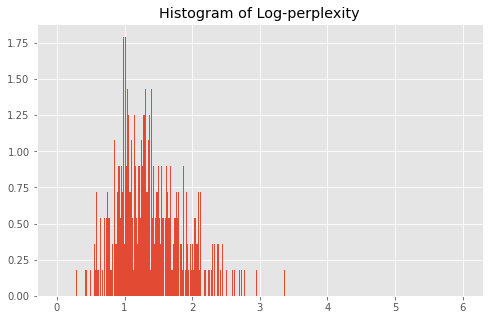

In [136]:
datar.response.hist(bins=np.linspace(0,6,501), density=True)
plt.title("Histogram of Log-perplexity")
plt.savefig(f"Figs/{filename}.png")

In [132]:
data[data['length'] > 60]

,Unnamed: 0,num,length,response,context_length,name
422,422,5,88,2.251846,16,43944
466,466,3,62,1.634977,37,7980


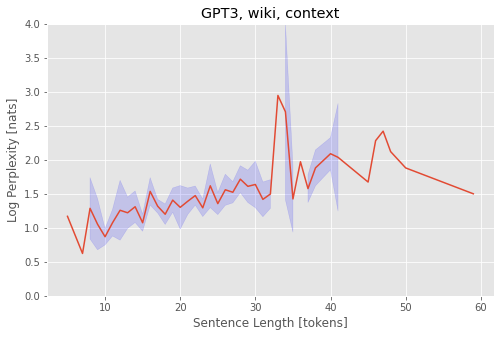

In [137]:
plot_perp_vs_len(datar, min_len=5, max_len=60)
plt.title("GPT3, wiki, context")
plt.savefig(f"Figs/logperp_vs_len_{filename}.png")
plt.show()

# Analyze Data

In [10]:
data = pd.read_csv("~/Google Drive/Data/gpt_wiki.csv")[['gpt', 'wiki']]

In [4]:
data_gpt = pd.read_csv("results/gpt_sent_perp_0.csv")

In [6]:
from glob import glob

def read_all_csv_files(pattern):
    df = pd.DataFrame()
    for f in glob(pattern):
        df = pd.concat([df, pd.read_csv(f)])
    return df

In [7]:
data_wiki = read_all_csv_files("results/wiki_sent_perp_*.csv")
data_gpt = read_all_csv_files("results/gpt_sent_perp_*.csv")
print(data_wiki.shape)
print(data_gpt.shape)

(474514, 5)
(654773, 5)


In [8]:
data_wiki['author'] = 'wiki'
data_gpt['author'] = 'gpt'

In [9]:
datam = pd.concat([data_gpt, data_wiki])

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, RocCurveDisplay
fpr, tpr, thresholds = roc_curve(y_true=datam.author, y_score=datam.logloss, pos_label='wiki')

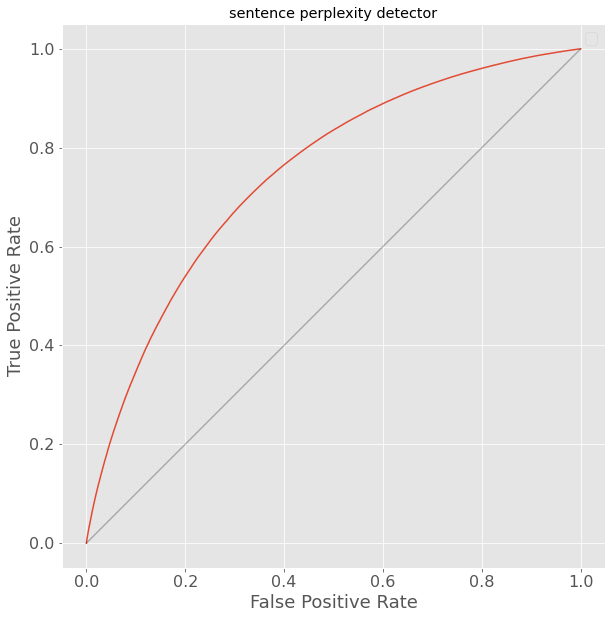

In [125]:
display = RocCurveDisplay(fpr=fpr, tpr=tpr)
display.plot(label='logloss')
plt.plot([0, 1], [0, 1], "k", alpha=.25)
plt.axis("square")
plt.xlabel("False Positive Rate", fontsize=18)
plt.ylabel("True Positive Rate", fontsize=18)
plt.xticks(fontsize=16); plt.yticks(fontsize=16)
fig = plt.gcf()
fig.set_size_inches(10, 10, forward=True)
plt.legend([],fontsize=16)
plt.title("sentence perplexity detector")
plt.savefig("ROC_sentences.png")
plt.show()

In [139]:
kurt = lambda x : scipy.stats.kurtosis(x)
agg_stats = datam.groupby('author').logloss.agg(['mean','median', 'std', 'skew', kurt])
agg_stats

,mean,median,std,skew,<lambda_0>
author,,,,,
gpt,3.530244,3.452712,0.758076,0.69616,1.202960
wiki,4.257753,4.191270,0.856725,0.60649,1.218302


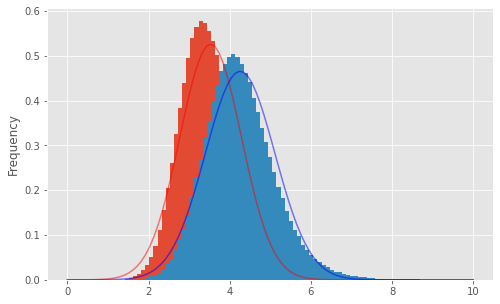

In [127]:
from scipy.stats import norm
tt = np.linspace(0,10,100)
datam.groupby('author').logloss.plot.hist(bins = tt, density=True)
plt.plot(tt, norm.pdf(tt, loc=agg_stats.loc['gpt','mean'], scale=agg_stats.loc['gpt','std']), 'r', alpha=0.5)
plt.plot(tt, norm.pdf(tt, loc=agg_stats.loc['wiki','mean'], scale=agg_stats.loc['wiki','std']), 'b',  alpha=0.5)
plt.show()

## Under noraml approximation:
$$
Z_1 \sim N(\mu_1, \sigma^2),\quad Z_2 \sim N(\mu_2, \sigma^2)
$$
$$
Z = \frac{Z_1 - Z_2}{\sqrt{2}\sigma} \sim N(\mu_1 - \mu_2 , 1) 
$$


In [109]:
m1, m2 = datam.groupby('author').logloss.mean()
s1, s2 = datam.groupby('author').logloss.std()
s = (s1 + s2) / 2
m = (m2 - m1) / s / np.sqrt(2)
m

0.63722705594959

In [40]:
n = 10000
r = m**2 / 2 / n

def rho_inv(r):
    if r > 1: return np.nan
    return (r + 1/2) * (r < .25) + (1 - (1 - np.sqrt(r))**2) * (r >= 0.25) 

beta = rho_inv(r)
k = n ** (1-beta)
print("~ num of edits needed: ", k)

~ num of edits needed:  99.98139079989893


In [46]:
def fit_pval_func(xx, G = 501):
    qq = np.linspace(0, 1, G)
    yy = [np.quantile(xx, q) for q in qq]
    return interp1d(yy, 1-qq, fill_value = (1,0), bounds_error=False)

In [62]:
pval_func = {}
for c in data_gpt.groupby(['length']):
    pval_func[c[0]] = fit_pval_func(c[1].logloss)

In [39]:
def pval_per_sentence(texts, model, tokenizer, pval_func):
    pvals = []
    for text in texts:
        x = logloss(model, tokenizer, text)
        pval = pval_func()
        pvals.append(pval) 
    return pvals

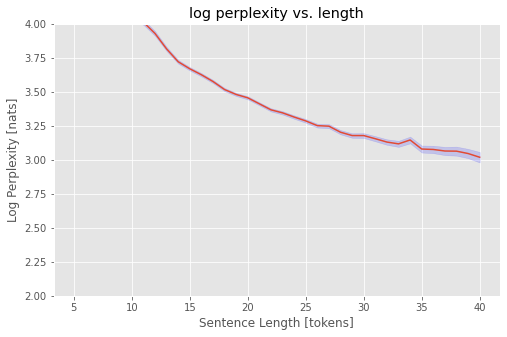

In [77]:
def plot_perp_vs_len(data, min_len=5, max_len=40):
    df_grouped = (
        data[['length', 'logloss']][(data['length'] >= min_len) 
                                        & (data['length'] <= max_len)
                                       ].groupby(['length']).agg(['mean', 'std', 'count'])
    )
    df_grouped = df_grouped.droplevel(axis=1, level=0).reset_index()
    # Calculate a confidence interval as well.
    df_grouped['ci'] = 1.96 * df_grouped['std'] / np.sqrt(df_grouped['count'])
    df_grouped['ci_lower'] = df_grouped['mean'] - df_grouped['ci']
    df_grouped['ci_upper'] = df_grouped['mean'] + df_grouped['ci']
    df_grouped.head()


    fig, ax = plt.subplots()
    x = df_grouped['length']
    ax.plot(x, df_grouped['mean'])
    ax.fill_between(
        x, df_grouped['ci_lower'], df_grouped['ci_upper'], color='b', alpha=.15)
    ax.set_ylim(ymin=0)
    ax.set_title('log perplexity vs. length')
    ax.set_xlabel("Sentence Length [tokens]")
    ax.set_ylabel("Log Perplexity [nats]")
    ax.set_ylim((2,4))
    plt.rcParams["figure.figsize"] = (8,5)
    

plot_perp_vs_len(data_gpt, min_len=5, max_len=40)
plt.savefig("logperp_vs_len_gpt.png")
plt.show()

length
5     Axes(0.125,0.125;0.775x0.755)
10    Axes(0.125,0.125;0.775x0.755)
20    Axes(0.125,0.125;0.775x0.755)
Name: logloss, dtype: object

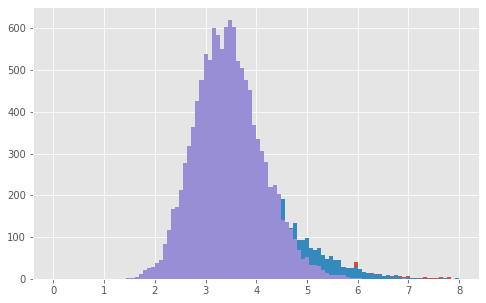

In [90]:
data_gpt[data_gpt.length.isin([5, 10, 20])].groupby('length').logloss.hist(bins=np.linspace(0,8,101))